# Segmentation of Cells On Microscope Images using UNet

## 0. Imports and install packeges

In [1]:
import torch
import torchvision
from torchvision import datasets
from pycocotools import mask as coco_mask
import matplotlib.pyplot as plt
import zipfile
import random

## 1. Get the dataset

### 1.1 Donwload images

In [2]:
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip

--2024-02-03 17:41:27--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/images.zip
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.171.126, 52.219.72.225, 3.5.139.196, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.171.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1241715651 (1.2G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   1.16G  25.4MB/s    in 48s     

2024-02-03 17:42:15 (24.9 MB/s) - ‘images.zip’ saved [1241715651/1241715651]



In [3]:
dataset_path_zip = '/content/images.zip'
zipfile.ZipFile(dataset_path_zip).extractall('/content/')

In [4]:
# 5% of the train annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json

# Validation and Test annotations
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
!wget http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_test.json

--2024-02-03 17:42:29--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell_dataset_size_split/2_train5percent.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 52.219.75.180, 3.5.139.192, 3.5.135.15, ...
Connecting to livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)|52.219.75.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27988522 (27M) [application/json]
Saving to: ‘2_train5percent.json’

2_train5percent.jso 100%[===================>]  26.69M  14.7MB/s    in 1.8s    

2024-02-03 17:42:32 (14.7 MB/s) - ‘2_train5percent.json’ saved [27988522/27988522]

--2024-02-03 17:42:32--  http://livecell-dataset.s3.eu-central-1.amazonaws.com/LIVECell_dataset_2021/annotations/LIVECell/livecell_coco_val.json
Resolving livecell-dataset.s3.eu-central-1.amazonaws.com (livecell-dataset.s3.eu-central-1.amazonaws.com)... 

### 1.2 Create custom datasets and Visualizing random images of dataset

In [91]:
from torch.utils.data import Dataset
from torchvision.datasets import CocoDetection
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.patches as patches

class CocoSegmentationDataset(Dataset):
    def __init__(self, root, annFile, transform=None, target_transform=None):
        self.coco_dataset = CocoDetection(root=root, annFile=annFile, transform=transform, target_transform=target_transform)

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        img, targets = self.coco_dataset[idx]
        # image_height, image_width = img.size[1], img.size[0]
        # masks = []
        # for target in targets:
        #     if 'segmentation' in target:  # Check if segmentation information is available
        #         segmentation = target['segmentation']
        #         if isinstance(segmentation, list):  # Polygonal representation
        #             mask = self.create_polygon_mask(segmentation, img.size)
        #         elif isinstance(segmentation, dict) and 'counts' in segmentation and 'size' in segmentation:  # RLE representation
        #             mask = self.create_rle_mask(segmentation, img.size)
        #         else:
        #             raise ValueError("Unsupported segmentation representation")
        #         masks.append(mask)
        # if masks:
        #     combined_mask = np.zeros((image_height, image_width), dtype=np.uint8)
        #     for mask in masks:
        #         combined_mask += mask
        #     combined_mask = (combined_mask > 0).astype(np.uint8) * 255  # Convert to binary mask
        # else:
        #     combined_mask = np.zeros((image_height, image_width), dtype=np.uint8)
        # return img, Image.fromarray(combined_mask)
        return img, targets
    def show_random_samples(self, qty: int=5) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=qty)

      fig = plt.figure(figsize=(15, 15))

      for i, sample in enumerate(random_samples):
        fig.add_subplot(1, qty, i+1)
        plt.imshow(self.coco_dataset[sample][0])
        plt.axis('off')

    def show_random_samples_with_annotations_poligons(self, fill_polygons: bool=False) -> None:
      random_samples = random.sample(range(len(self.coco_dataset)), k=4)

      # fig = plt.figure(figsize=(15, 15))
      fig, axs = plt.subplots(2, 2, figsize=(15, 15))

      for idx, ax in enumerate(axs.flat):
        for i, sample in enumerate(random_samples):
          # fig.add_subplot(1, qty, i+1)
          ax.imshow(self.coco_dataset[sample][0])
          ax.axis('off')

          annotations = self.coco_dataset[sample][1]
          for ann in annotations:
            for seg in ann['segmentation']:
              if type(seg) is list:
                poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                polygon = plt.Polygon(poly, closed=True, edgecolor='g', fill=fill_polygons, facecolor='none')
                ax.add_patch(polygon)


    def create_polygon_mask(self, segmentation, image_size):
        mask = Image.new('L', image_size, 0)
        draw = ImageDraw.Draw(mask)
        for seg in segmentation:
            draw.polygon(seg, outline=1, fill=1)
        return mask

    def create_rle_mask(self, segmentation, image_size):
        mask = Image.new('L', image_size, 0)
        draw = ImageDraw.Draw(mask)
        draw.rectangle((0, 0, image_size[0], image_size[1]), fill=0)  # Fill with 0 initially
        for counts in segmentation['counts']:
            rle = np.array(counts).reshape((-1, 2))
            for start, length in rle:
                draw.rectangle((start, 0, start + length, image_size[1]), fill=1)  # Fill with 1 in specified region
        return mask


In [53]:
# Train, Val and Test images and annotation paths
train_dataset_image_root_path = '/content/images/livecell_train_val_images'
train_dataset_annotations_root_path = '/content/2_train5percent.json'

val_dataset_image_root_path = '/content/images/livecell_train_val_images'
val_dataset_annotations_root_path = '/content/livecell_coco_val.json'

test_dataset_image_root_path = '/content/images/livecell_test_images'
test_dataset_annotations_root_path = '/content/livecell_coco_test.json'

In [ ]:
# Train dataset (only 5%)
train_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path, annFile=train_dataset_annotations_root_path);

In [97]:
val_dataset = CocoSegmentationDataset(root=train_dataset_image_root_path, annFile=val_dataset_annotations_root_path)

loading annotations into memory...
Done (t=7.51s)
creating index...
index created!


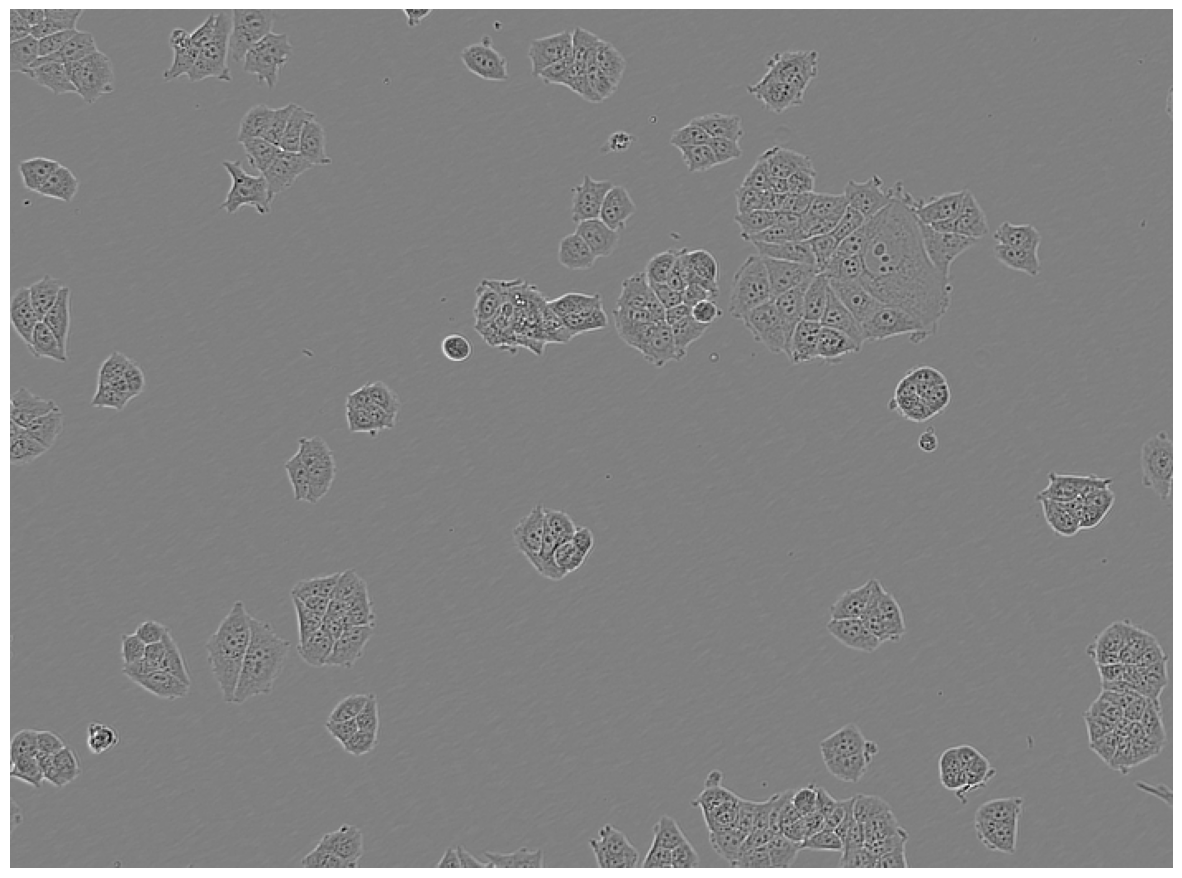

In [95]:
train_dataset.show_random_samples(qty=1)

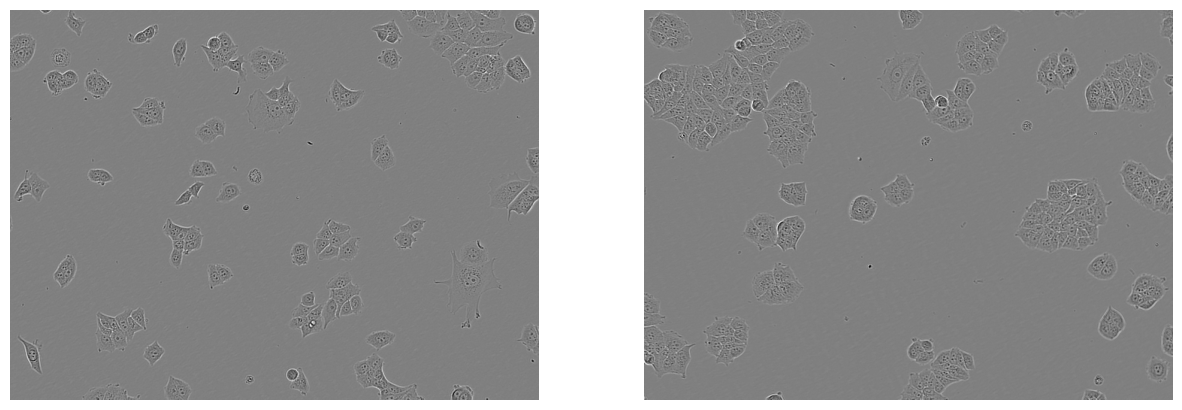

In [14]:
val_dataset.show_random_samples(qty=2)

### 1.3 Visualizing the annotations of a image


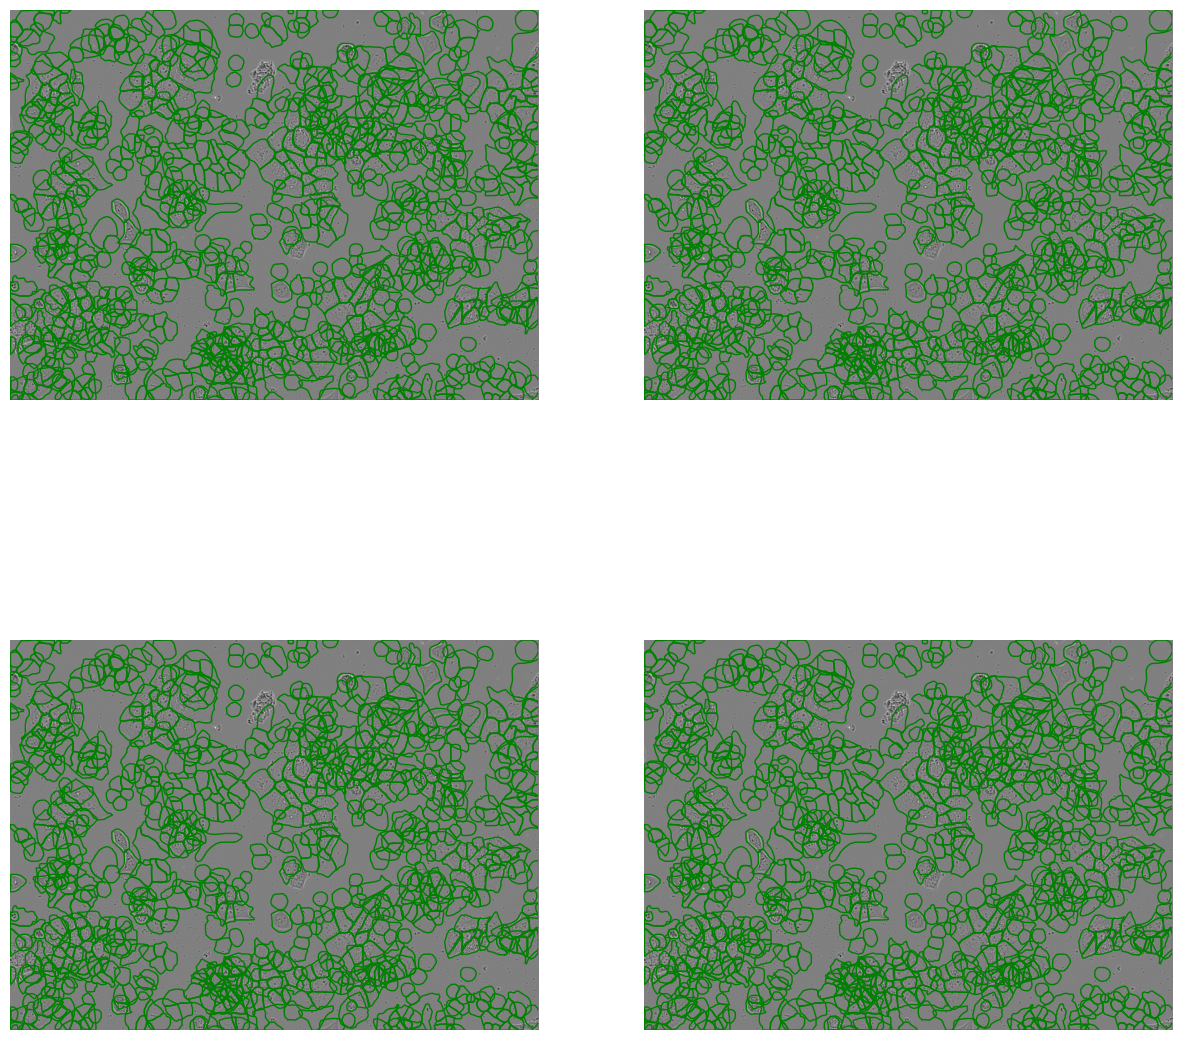

In [93]:
train_dataset.show_random_samples_with_annotations_poligons()

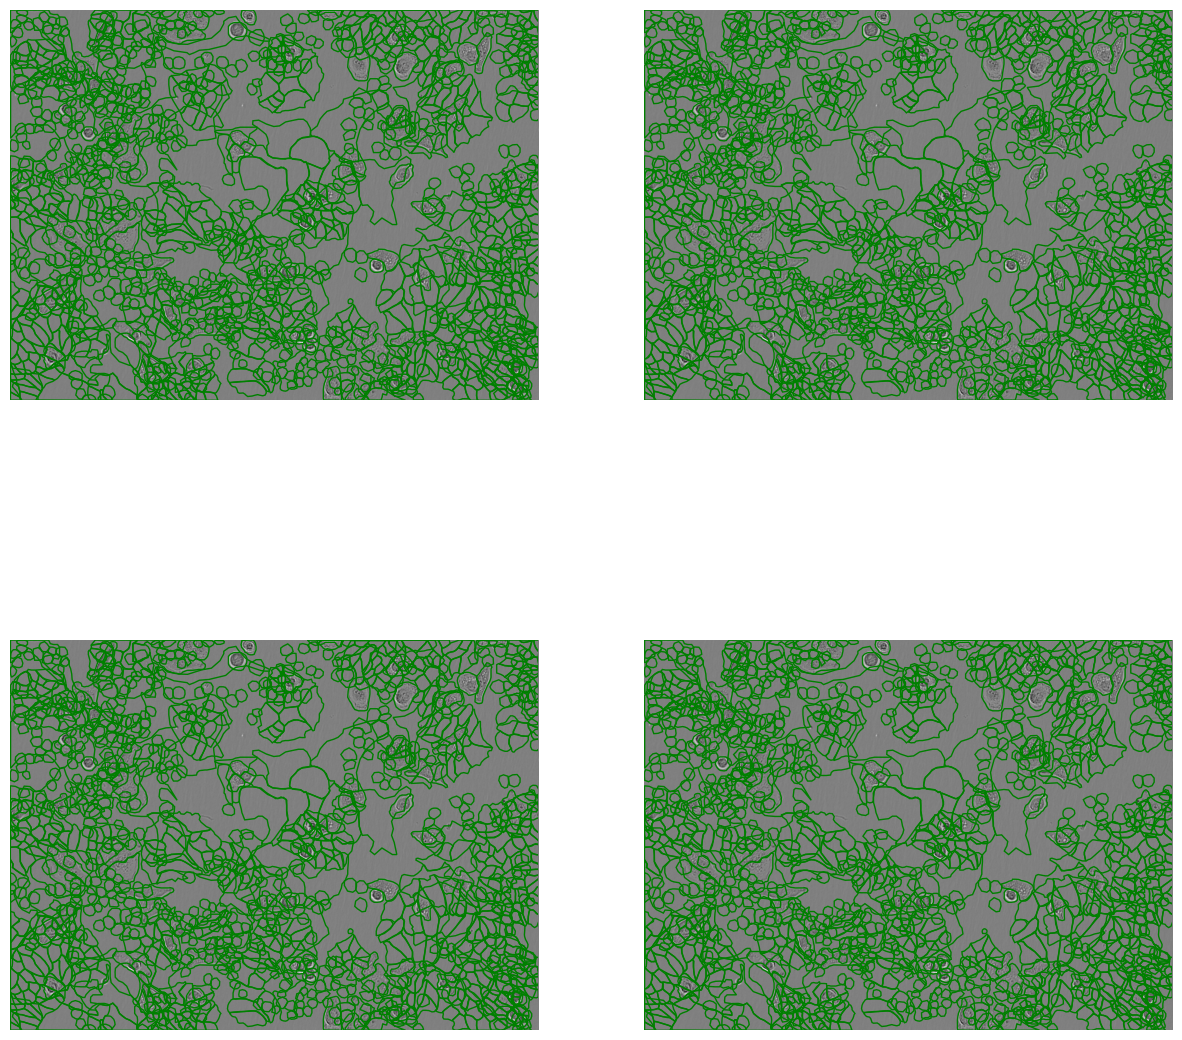

In [98]:
val_dataset.show_random_samples_with_annotations_poligons()

### 1.3 Visualizing the maks segmentation

### 1.4 Visualizing random images and its respective masks